# Category-Level TabPFN Forecasting

Generate 2026 forecasts for each retail category using TabPFN with regime dummies only.

**Three forecast scenarios**:
- **Scenario A (Reversion)**: Pre-COVID dynamics continue (`d_cov=0, d_post=0`)
- **Scenario B (COVID Persistence)**: COVID dynamics persist (`d_cov=1, d_post=0`)
- **Scenario C (Post-COVID Baseline)**: Post-COVID dynamics persist (`d_cov=1, d_post=1`)

**Features**: Regime dummies (`d_cov`, `d_post`) + Calendar features (`month`, `quarter`)

## 0. Setup

In [1]:
import pandas as pd
import numpy as np
import pickle
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from autogluon.timeseries import TimeSeriesDataFrame
from tabpfn_time_series import TabPFNTimeSeriesPredictor, TabPFNMode
from sktime.performance_metrics.forecasting import mean_absolute_error, mean_absolute_scaled_error
from sktime.performance_metrics.forecasting.probabilistic import PinballLoss

In [2]:
# Chart style settings
import matplotlib.style as style
style.use({
    'font.family': 'Monospace',
    'font.size': 10,
})

In [3]:
# Data folders
processed_data_dir = Path.cwd().parent / "data" / "processed"
output_figures_dir = Path.cwd().parent / "outputs" / "figures"
output_figures_dir.mkdir(parents=True, exist_ok=True)

In [4]:
# Constants
HORIZON = 12  # Forecast horizon for evaluation
FORECAST_END = pd.Timestamp('2026-12-31')  # Forecast to end of 2026

### TabPFN Client Setup

In [5]:
import tabpfn_client
import dotenv
import os

# Load API key from .env
if os.getenv("PRIORLABS_API_KEY") is None:
    raise ValueError("Please set the PRIORLABS_API_KEY in the .env file")

dotenv.load_dotenv()
token = dotenv.get_key(dotenv.find_dotenv(), "PRIORLABS_API_KEY")
tabpfn_client.set_access_token(token)

print("✅ TabPFN client initialized")

✅ TabPFN client initialized


### Load Data

In [6]:
# Load category data with regime dummies
df_categories = pd.read_pickle(processed_data_dir / "category_data_with_regimes.pkl")

# Load regime analysis results
with open(processed_data_dir / "category_regime_analysis.pkl", 'rb') as f:
    regime_results = pickle.load(f)

print(f"Loaded {len(df_categories.columns)} columns")
print(f"Time range: {df_categories.index.min()} to {df_categories.index.max()}")
print(f"Total observations: {len(df_categories)}")
print(f"\nColumns: {df_categories.columns.tolist()}")

Loaded 10 columns
Time range: 2015-01-31 00:00:00 to 2025-07-31 00:00:00
Total observations: 127

Columns: ['all_retail_ex_fuel', 'food_stores', 'non_food_total', 'non_specialised', 'clothing_footwear', 'household_goods', 'other_stores', 'non_store_retail', 'd_cov', 'd_post']


In [7]:
# Define categories to forecast (exclude aggregates)
CATEGORIES = [
    'food_stores',
    'clothing_footwear',
    'household_goods',
    'non_specialised',
    'other_stores',
    'non_store_retail'
]

print(f"Will forecast {len(CATEGORIES)} categories")

Will forecast 6 categories


## 1. Helper Functions

In [8]:
def prepare_category_tsdf(df, category, train_end_date):
    """
    Prepare TimeSeriesDataFrame for a category with regime dummies and calendar features.

    Parameters
    ----------
    df : pd.DataFrame
        Category data with regime dummies (d_cov, d_post)
    category : str
        Category column name
    train_end_date : pd.Timestamp
        Last date to include in training data

    Returns
    -------
    train_tsdf : TimeSeriesDataFrame
        Training data
    test_tsdf_ground_truth : TimeSeriesDataFrame
        Test data with ground truth (for evaluation)
    """
    # Filter to training period
    df_train = df[df.index <= train_end_date].copy()

    # Prepare dataframe for TimeSeriesDataFrame
    df_prep = df_train.reset_index()
    # Index is named 'date' from category data, need to rename to 'timestamp'
    df_prep = df_prep.rename(columns={category: 'target'})
    if df_prep.index.name == 'date':
        df_prep = df_prep.reset_index()
    if 'date' in df_prep.columns:
        df_prep = df_prep.rename(columns={'date': 'timestamp'})
    df_prep['item_id'] = category

    # Add calendar features
    df_prep['month'] = df_prep['timestamp'].dt.month
    df_prep['quarter'] = df_prep['timestamp'].dt.quarter

    # Select columns: target, regime dummies, calendar
    cols = ['item_id', 'timestamp', 'target', 'd_cov', 'd_post', 'month', 'quarter']
    df_prep = df_prep[cols]

    # Create TimeSeriesDataFrame
    train_tsdf = TimeSeriesDataFrame.from_data_frame(
        df_prep,
        id_column='item_id',
        timestamp_column='timestamp',
        static_features_df=None
    )

    # Create ground truth test set (for evaluation)
    df_test = df[df.index > train_end_date].copy()
    df_test_prep = df_test.reset_index()
    df_test_prep = df_test_prep.rename(columns={category: 'target'})
    if df_test_prep.index.name == 'date':
        df_test_prep = df_test_prep.reset_index()
    if 'date' in df_test_prep.columns:
        df_test_prep = df_test_prep.rename(columns={'date': 'timestamp'})
    df_test_prep['item_id'] = category
    df_test_prep['month'] = df_test_prep['timestamp'].dt.month
    df_test_prep['quarter'] = df_test_prep['timestamp'].dt.quarter
    df_test_prep = df_test_prep[cols]

    test_tsdf_ground_truth = TimeSeriesDataFrame.from_data_frame(
        df_test_prep,
        id_column='item_id',
        timestamp_column='timestamp',
        static_features_df=None
    )

    return train_tsdf, test_tsdf_ground_truth

In [9]:
def create_scenario_test_tsdf(category, test_dates, scenario='C'):
    """
    Create test TimeSeriesDataFrame with scenario-specific regime dummies.

    Parameters
    ----------
    category : str
        Category name
    test_dates : pd.DatetimeIndex
        Forecast dates
    scenario : str, {'A', 'B', 'C'}
        Scenario type:
        - 'A': Reversion (d_cov=0, d_post=0)
        - 'B': COVID Persistence (d_cov=1, d_post=0)
        - 'C': Post-COVID Baseline (d_cov=1, d_post=1)

    Returns
    -------
    test_tsdf : TimeSeriesDataFrame
        Test data with NaN target and scenario-specific regime dummies
    """
    # Define regime dummy values per scenario
    scenario_regimes = {
        'A': {'d_cov': 0, 'd_post': 0},  # Pre-COVID
        'B': {'d_cov': 1, 'd_post': 0},  # COVID
        'C': {'d_cov': 1, 'd_post': 1}   # Post-COVID
    }

    regimes = scenario_regimes[scenario]

    # Create test dataframe
    test_df = pd.DataFrame({
        'timestamp': test_dates,
        'item_id': category,
        'target': np.nan,
        'd_cov': regimes['d_cov'],
        'd_post': regimes['d_post'],
        'month': test_dates.month,
        'quarter': test_dates.quarter
    })

    # Create TimeSeriesDataFrame
    test_tsdf = TimeSeriesDataFrame.from_data_frame(
        test_df,
        id_column='item_id',
        timestamp_column='timestamp',
        static_features_df=None
    )

    return test_tsdf

In [10]:
def evaluate_category_forecast(pred, train_tsdf, test_tsdf_ground_truth, category, horizon=12):
    """
    Evaluate TabPFN forecast for a category.

    Parameters
    ----------
    pred : pd.DataFrame
        TabPFN predictions (MultiIndex with quantiles)
    train_tsdf : TimeSeriesDataFrame
        Training data
    test_tsdf_ground_truth : TimeSeriesDataFrame
        Test data with ground truth
    category : str
        Category name
    horizon : int
        Forecast horizon for evaluation

    Returns
    -------
    dict : Metrics (MAE, MASE, pinball losses, coverage, interval width)
    """
    # Extract predictions
    pred_slice = pred.loc[category]

    # Extract ground truth (last horizon months)
    y_true_full = (
        test_tsdf_ground_truth
        .groupby('item_id')
        .tail(horizon)
        .loc[category]['target']
    )

    # Extract quantiles
    q_low = pred_slice[0.1]
    q_med = pred_slice[0.5]
    q_high = pred_slice[0.9]

    # Align by taking only the overlapping timestamps
    # Use inner join to ensure we only evaluate on matching timestamps
    common_index = q_med.index.intersection(y_true_full.index)

    if len(common_index) == 0:
        raise ValueError(f"No overlapping timestamps between predictions and ground truth for {category}")

    # Filter to common timestamps
    y_true = y_true_full.loc[common_index]
    q_low = q_low.loc[common_index]
    q_med = q_med.loc[common_index]
    q_high = q_high.loc[common_index]

    # Verify no NaN values
    if y_true.isna().any():
        raise ValueError(f"Ground truth contains NaN values for {category}")

    # Point metrics
    mae = float(mean_absolute_error(y_true, q_med))

    # MASE
    y_train = train_tsdf.loc[category]['target']
    mase = float(mean_absolute_scaled_error(y_true, q_med, y_train=y_train, sp=12))

    # Probabilistic metrics
    pinball = PinballLoss()

    y_pred_low = pd.DataFrame(
        q_low.values,
        index=q_low.index,
        columns=pd.MultiIndex.from_tuples([('target', 0.1)], names=['variable', 'alpha'])
    )

    y_pred_high = pd.DataFrame(
        q_high.values,
        index=q_high.index,
        columns=pd.MultiIndex.from_tuples([('target', 0.9)], names=['variable', 'alpha'])
    )

    pin_low = float(pinball(y_true, y_pred_low))
    pin_high = float(pinball(y_true, y_pred_high))

    # Coverage and interval width
    coverage_80 = float(((y_true >= q_low) & (y_true <= q_high)).mean())
    interval_width = float((q_high - q_low).mean())

    return {
        'mae': mae,
        'mase': mase,
        'pinball_0.1': pin_low,
        'pinball_0.9': pin_high,
        'coverage_80': coverage_80,
        'mean_interval_width': interval_width
    }

In [11]:
def plot_category_forecast(pred, train_tsdf, test_tsdf_ground_truth, category, scenario, save_path=None):
    """
    Plot category forecast with confidence intervals.

    Parameters
    ----------
    pred : pd.DataFrame
        TabPFN predictions
    train_tsdf : TimeSeriesDataFrame
        Training data
    test_tsdf_ground_truth : TimeSeriesDataFrame
        Test data with ground truth
    category : str
        Category name
    scenario : str
        Scenario label
    save_path : str, optional
        Path to save figure
    """
    # Prepare data
    train_df = (
        train_tsdf.loc[category]
        .reset_index()
        .assign(series='train')
        .rename(columns={'target': 'value'})
    )

    actual_df = (
        test_tsdf_ground_truth.loc[category]
        .reset_index()
        .assign(series='actual')
        .rename(columns={'target': 'value'})
    )

    med_df = (
        pred.loc[category, 0.5]
        .to_frame('value')
        .reset_index()
        .assign(series='forecast')
    )

    lo_df = (
        pred.loc[category, 0.1]
        .to_frame('value')
        .reset_index()
        .assign(series='lower80')
    )

    hi_df = (
        pred.loc[category, 0.9]
        .to_frame('value')
        .reset_index()
        .assign(series='upper80')
    )

    plot_df = pd.concat([train_df, actual_df, med_df, lo_df, hi_df], ignore_index=True)

    # Plot
    fig, ax = plt.subplots(figsize=(16, 5), dpi=300)

    sns.lineplot(data=plot_df.query("series == 'train'"), x='timestamp', y='value',
                 linewidth=1.5, color='grey', label='train', ax=ax)
    sns.lineplot(data=plot_df.query("series == 'actual'"), x='timestamp', y='value',
                 linewidth=1.5, color='steelblue', label='actual', ax=ax)
    sns.lineplot(data=plot_df.query("series == 'forecast'"), x='timestamp', y='value',
                 linewidth=1.5, color='red', label='forecast (median)', ax=ax)

    lower = plot_df.query("series == 'lower80'").set_index('timestamp')['value']
    upper = plot_df.query("series == 'upper80'").set_index('timestamp')['value']
    ax.fill_between(lower.index, lower, upper, color='red', alpha=0.15, label='80% band')

    # Formatting
    time_range = pd.date_range(start=plot_df['timestamp'].min(), end=plot_df['timestamp'].max(), freq='YS')
    ax.set_xticks(time_range)
    ax.set_xticklabels([t.year for t in time_range])

    for tick in ax.get_xticks():
        ax.axvline(x=tick, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

    ax.legend(loc='upper left', fontsize=10)
    ax.set_xlabel('')
    ax.set_ylabel('Internet Sales as % of Category Total')
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.set_title(f'{category.replace("_", " ").title()}: Scenario {scenario}', loc='left', fontsize=12)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()

## 2. Test Helper Functions on One Category

In [12]:
# Test on food_stores category
test_category = 'food_stores'

# Split: train on data up to 2024-06-30, test on last 12 months
train_end = pd.Timestamp('2024-06-30')

# Prepare training data
train_tsdf, test_tsdf_ground_truth = prepare_category_tsdf(df_categories, test_category, train_end)

print(f"Category: {test_category}")
print(f"Train shape: {train_tsdf.shape}")
print(f"Test ground truth shape: {test_tsdf_ground_truth.shape}")
print(f"\nTrain date range: {train_tsdf.index.get_level_values('timestamp').min()} to {train_tsdf.index.get_level_values('timestamp').max()}")
print(f"Test date range: {test_tsdf_ground_truth.index.get_level_values('timestamp').min()} to {test_tsdf_ground_truth.index.get_level_values('timestamp').max()}")

Category: food_stores
Train shape: (114, 5)
Test ground truth shape: (13, 5)

Train date range: 2015-01-31 00:00:00 to 2024-06-30 00:00:00
Test date range: 2024-07-31 00:00:00 to 2025-07-31 00:00:00


In [13]:
# Create test set for Scenario C (baseline: post-COVID continues)
test_dates = test_tsdf_ground_truth.index.get_level_values('timestamp').unique()
test_tsdf = create_scenario_test_tsdf(test_category, test_dates, scenario='C')

print(f"Test set for Scenario C:")
print(f"Shape: {test_tsdf.shape}")
print(f"\nFirst 3 rows:")
print(test_tsdf.loc[test_category].head(3))

Test set for Scenario C:
Shape: (13, 5)

First 3 rows:
            target  d_cov  d_post  month  quarter
timestamp                                        
2024-07-31     NaN      1       1      7        3
2024-08-31     NaN      1       1      8        3
2024-09-30     NaN      1       1      9        3


## 3. Run TabPFN Forecast: Scenario C (Baseline)

In [14]:
# Initialize TabPFN predictor
predictor = TabPFNTimeSeriesPredictor(tabpfn_mode=TabPFNMode.CLIENT)

# Predict
pred_C = predictor.predict(train_tsdf, test_tsdf)

print(f"Prediction shape: {pred_C.shape}")
print(f"\nFirst 3 predictions (median):")
print(pred_C.loc[test_category, 0.5].head(3))

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 920.41it/s]


Processing: 100%|██████████| [00:01<00:00]


Prediction shape: (13, 10)

First 3 predictions (median):
timestamp
2024-07-31    8.839087
2024-08-31    8.844359
2024-09-30    8.871000
Name: 0.5, dtype: float64


In [15]:
# Evaluate Scenario C
metrics_C = evaluate_category_forecast(
    pred=pred_C,
    train_tsdf=train_tsdf,
    test_tsdf_ground_truth=test_tsdf_ground_truth,
    category=test_category,
    horizon=HORIZON
)

print(f"\n{test_category.replace('_', ' ').title()} - Scenario C Metrics:")
for key, val in metrics_C.items():
    print(f"  {key:20s}: {val:.4f}")


Food Stores - Scenario C Metrics:
  mae                 : 0.3744
  mase                : 0.3347
  pinball_0.1         : 0.0707
  pinball_0.9         : 0.0641
  coverage_80         : 0.7500
  mean_interval_width : 0.8697


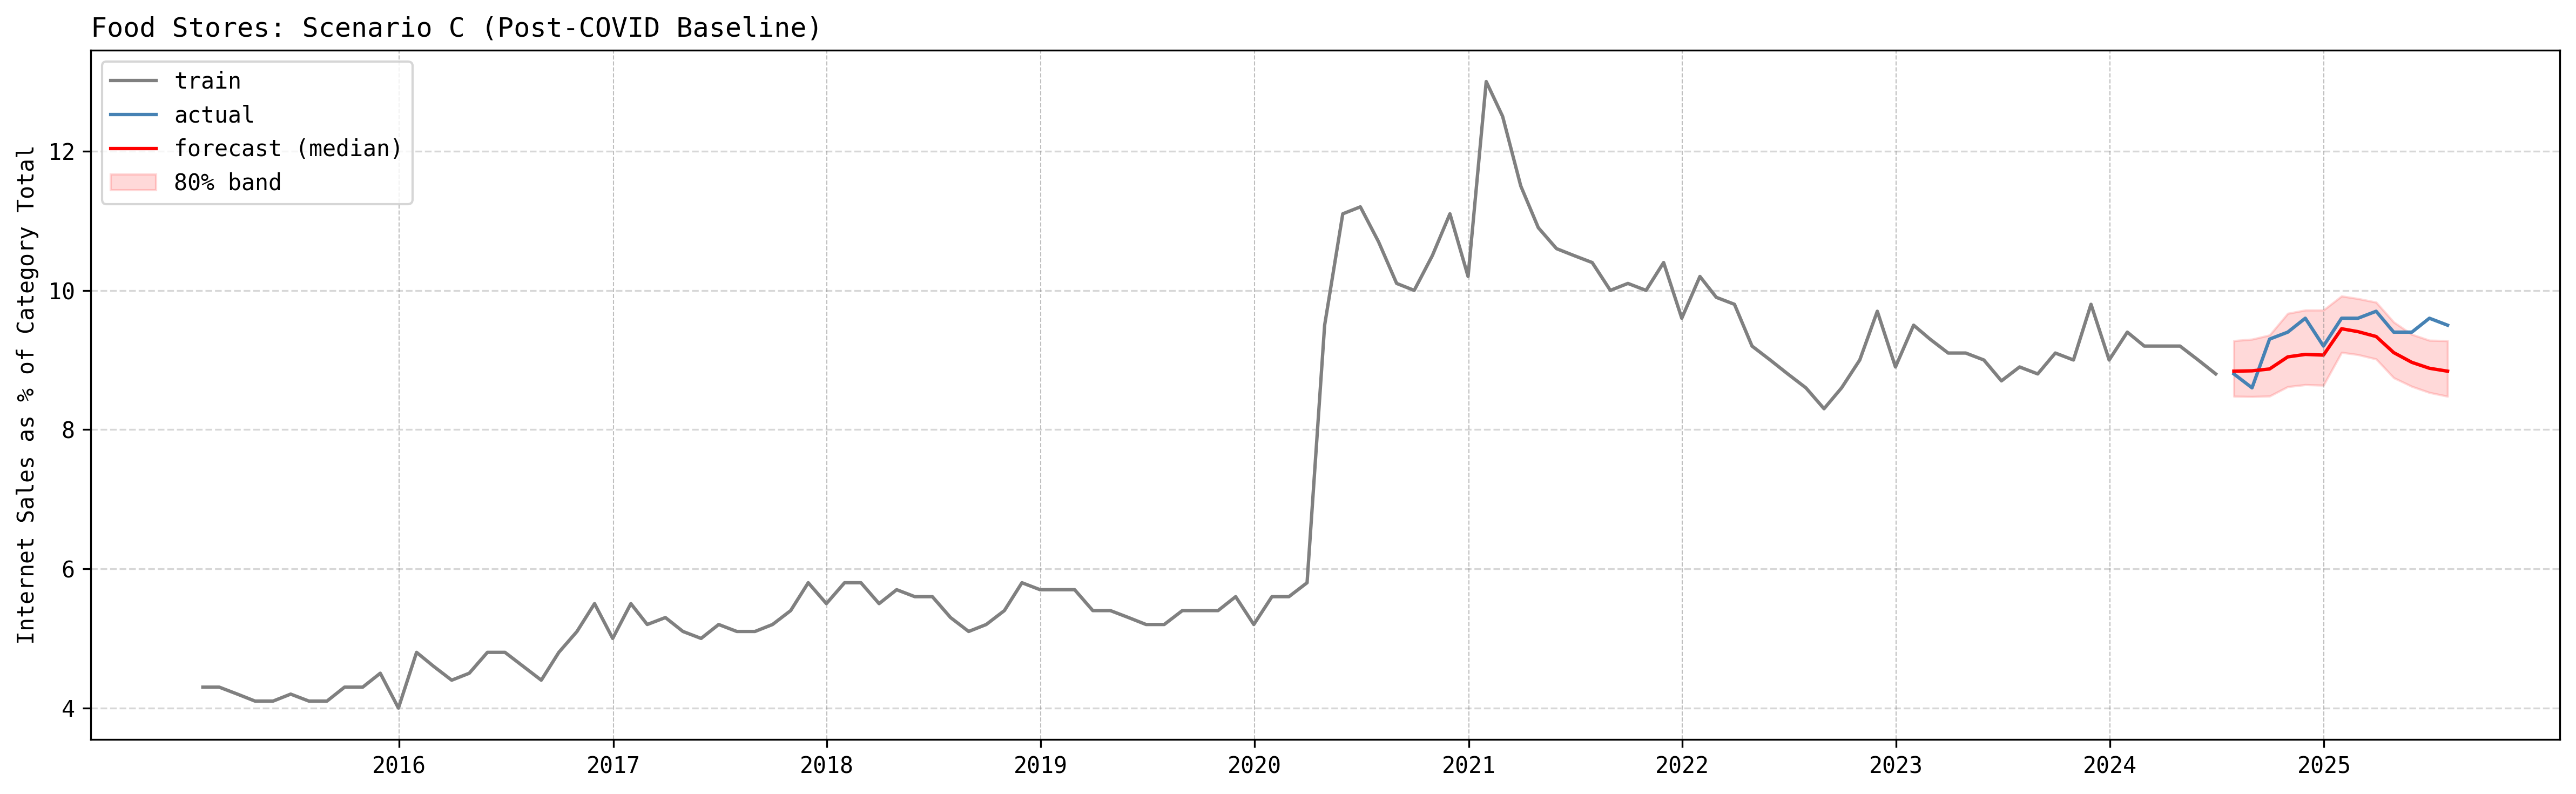

In [16]:
# Plot Scenario C
plot_category_forecast(
    pred=pred_C,
    train_tsdf=train_tsdf,
    test_tsdf_ground_truth=test_tsdf_ground_truth,
    category=test_category,
    scenario='C (Post-COVID Baseline)',
    save_path=output_figures_dir / f'{test_category}_scenario_C.png'
)

## 4. Run All Scenarios for Test Category

In [17]:
# Run Scenario A (Reversion)
test_tsdf_A = create_scenario_test_tsdf(test_category, test_dates, scenario='A')
pred_A = predictor.predict(train_tsdf, test_tsdf_A)
metrics_A = evaluate_category_forecast(pred_A, train_tsdf, test_tsdf_ground_truth, test_category, HORIZON)

print(f"\n{test_category.replace('_', ' ').title()} - Scenario A Metrics (Reversion):")
for key, val in metrics_A.items():
    print(f"  {key:20s}: {val:.4f}")

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1929.30it/s]
Processing: 100%|██████████| [00:01<00:00]



Food Stores - Scenario A Metrics (Reversion):
  mae                 : 4.2254
  mase                : 3.7773
  pinball_0.1         : 0.5141
  pinball_0.9         : 3.3498
  coverage_80         : 0.0000
  mean_interval_width : 1.4186


In [18]:
# Run Scenario B (COVID Persistence)
test_tsdf_B = create_scenario_test_tsdf(test_category, test_dates, scenario='B')
pred_B = predictor.predict(train_tsdf, test_tsdf_B)
metrics_B = evaluate_category_forecast(pred_B, train_tsdf, test_tsdf_ground_truth, test_category, HORIZON)

print(f"\n{test_category.replace('_', ' ').title()} - Scenario B Metrics (COVID Persistence):")
for key, val in metrics_B.items():
    print(f"  {key:20s}: {val:.4f}")

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1106.38it/s]
Processing: 100%|██████████| [00:01<00:00]


Food Stores - Scenario B Metrics (COVID Persistence):
  mae                 : 1.2073
  mase                : 1.0792
  pinball_0.1         : 0.3614
  pinball_0.9         : 0.2197
  coverage_80         : 0.0000
  mean_interval_width : 1.7954


In [19]:
# Compare scenarios
scenario_comparison = pd.DataFrame({
    'Scenario A (Reversion)': metrics_A,
    'Scenario B (COVID)': metrics_B,
    'Scenario C (Post-COVID)': metrics_C
}).T

print(f"\n{'=' * 80}")
print(f"SCENARIO COMPARISON: {test_category.replace('_', ' ').title()}")
print(f"{'=' * 80}")
print(scenario_comparison.round(4))
print(f"\nBest scenario by MAE: {scenario_comparison['mae'].idxmin()}")


SCENARIO COMPARISON: Food Stores
                            mae    mase  pinball_0.1  pinball_0.9  \
Scenario A (Reversion)   4.2254  3.7773       0.5141       3.3498   
Scenario B (COVID)       1.2073  1.0792       0.3614       0.2197   
Scenario C (Post-COVID)  0.3744  0.3347       0.0707       0.0641   

                         coverage_80  mean_interval_width  
Scenario A (Reversion)          0.00               1.4186  
Scenario B (COVID)              0.00               1.7954  
Scenario C (Post-COVID)         0.75               0.8697  

Best scenario by MAE: Scenario C (Post-COVID)


In [20]:
def plot_all_scenarios(pred_A, pred_B, pred_C, train_tsdf, test_tsdf_ground_truth, category, save_path=None):
    """
    Plot all 3 scenarios together against actual values.

    Parameters
    ----------
    pred_A : pd.DataFrame
        Scenario A predictions (Reversion)
    pred_B : pd.DataFrame
        Scenario B predictions (COVID Persistence)
    pred_C : pd.DataFrame
        Scenario C predictions (Post-COVID Baseline)
    train_tsdf : TimeSeriesDataFrame
        Training data
    test_tsdf_ground_truth : TimeSeriesDataFrame
        Test data with ground truth
    category : str
        Category name
    save_path : str, optional
        Path to save figure
    """
    # Prepare data
    train_df = (
        train_tsdf.loc[category]
        .reset_index()
        .assign(series='train')
        .rename(columns={'target': 'value'})
    )

    actual_df = (
        test_tsdf_ground_truth.loc[category]
        .reset_index()
        .assign(series='actual')
        .rename(columns={'target': 'value'})
    )

    # Scenario A (median only)
    med_A_df = (
        pred_A.loc[category, 0.5]
        .to_frame('value')
        .reset_index()
        .assign(series='Scenario A (Reversion)')
    )

    # Scenario B (median only)
    med_B_df = (
        pred_B.loc[category, 0.5]
        .to_frame('value')
        .reset_index()
        .assign(series='Scenario B (COVID)')
    )

    # Scenario C (median + confidence intervals)
    med_C_df = (
        pred_C.loc[category, 0.5]
        .to_frame('value')
        .reset_index()
        .assign(series='Scenario C (Post-COVID)')
    )

    lo_C_df = (
        pred_C.loc[category, 0.1]
        .to_frame('value')
        .reset_index()
        .assign(series='lower80_C')
    )

    hi_C_df = (
        pred_C.loc[category, 0.9]
        .to_frame('value')
        .reset_index()
        .assign(series='upper80_C')
    )

    plot_df = pd.concat([train_df, actual_df, med_A_df, med_B_df, med_C_df, lo_C_df, hi_C_df], ignore_index=True)

    # Plot
    fig, ax = plt.subplots(figsize=(16, 6), dpi=300)

    # Historical data
    sns.lineplot(data=plot_df.query("series == 'train'"), x='timestamp', y='value',
                 linewidth=1.5, color='grey', label='Historical', ax=ax, alpha=0.6)

    # Actual test values
    sns.lineplot(data=plot_df.query("series == 'actual'"), x='timestamp', y='value',
                 linewidth=2.5, color='black', label='Actual', ax=ax, marker='o', markersize=4)

    # Scenarios
    sns.lineplot(data=plot_df.query("series == 'Scenario A (Reversion)'"), x='timestamp', y='value',
                 linewidth=1.5, color='green', label='Scenario A (Reversion)', ax=ax, linestyle='--', alpha=0.8)

    sns.lineplot(data=plot_df.query("series == 'Scenario B (COVID)'"), x='timestamp', y='value',
                 linewidth=1.5, color='orange', label='Scenario B (COVID)', ax=ax, linestyle='--', alpha=0.8)

    sns.lineplot(data=plot_df.query("series == 'Scenario C (Post-COVID)'"), x='timestamp', y='value',
                 linewidth=2, color='steelblue', label='Scenario C (Post-COVID)', ax=ax)

    # Confidence interval for Scenario C only
    lower_C = plot_df.query("series == 'lower80_C'").set_index('timestamp')['value']
    upper_C = plot_df.query("series == 'upper80_C'").set_index('timestamp')['value']
    ax.fill_between(lower_C.index, lower_C, upper_C, color='steelblue', alpha=0.15, label='Scenario C 80% band')

    # Formatting
    time_range = pd.date_range(start=plot_df['timestamp'].min(), end=plot_df['timestamp'].max(), freq='YS')
    ax.set_xticks(time_range)
    ax.set_xticklabels([t.year for t in time_range])

    for tick in ax.get_xticks():
        ax.axvline(x=tick, color='gray', linestyle='--', linewidth=0.5, alpha=0.5)

    ax.legend(loc='upper left', fontsize=10, framealpha=0.9)
    ax.set_xlabel('')
    ax.set_ylabel('Internet Sales as % of Category Total')
    ax.grid(axis='y', linestyle='--', alpha=0.5)
    ax.set_title(f'{category.replace("_", " ").title()}: All Scenarios vs Actual', loc='left', fontsize=12, fontweight='bold')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()

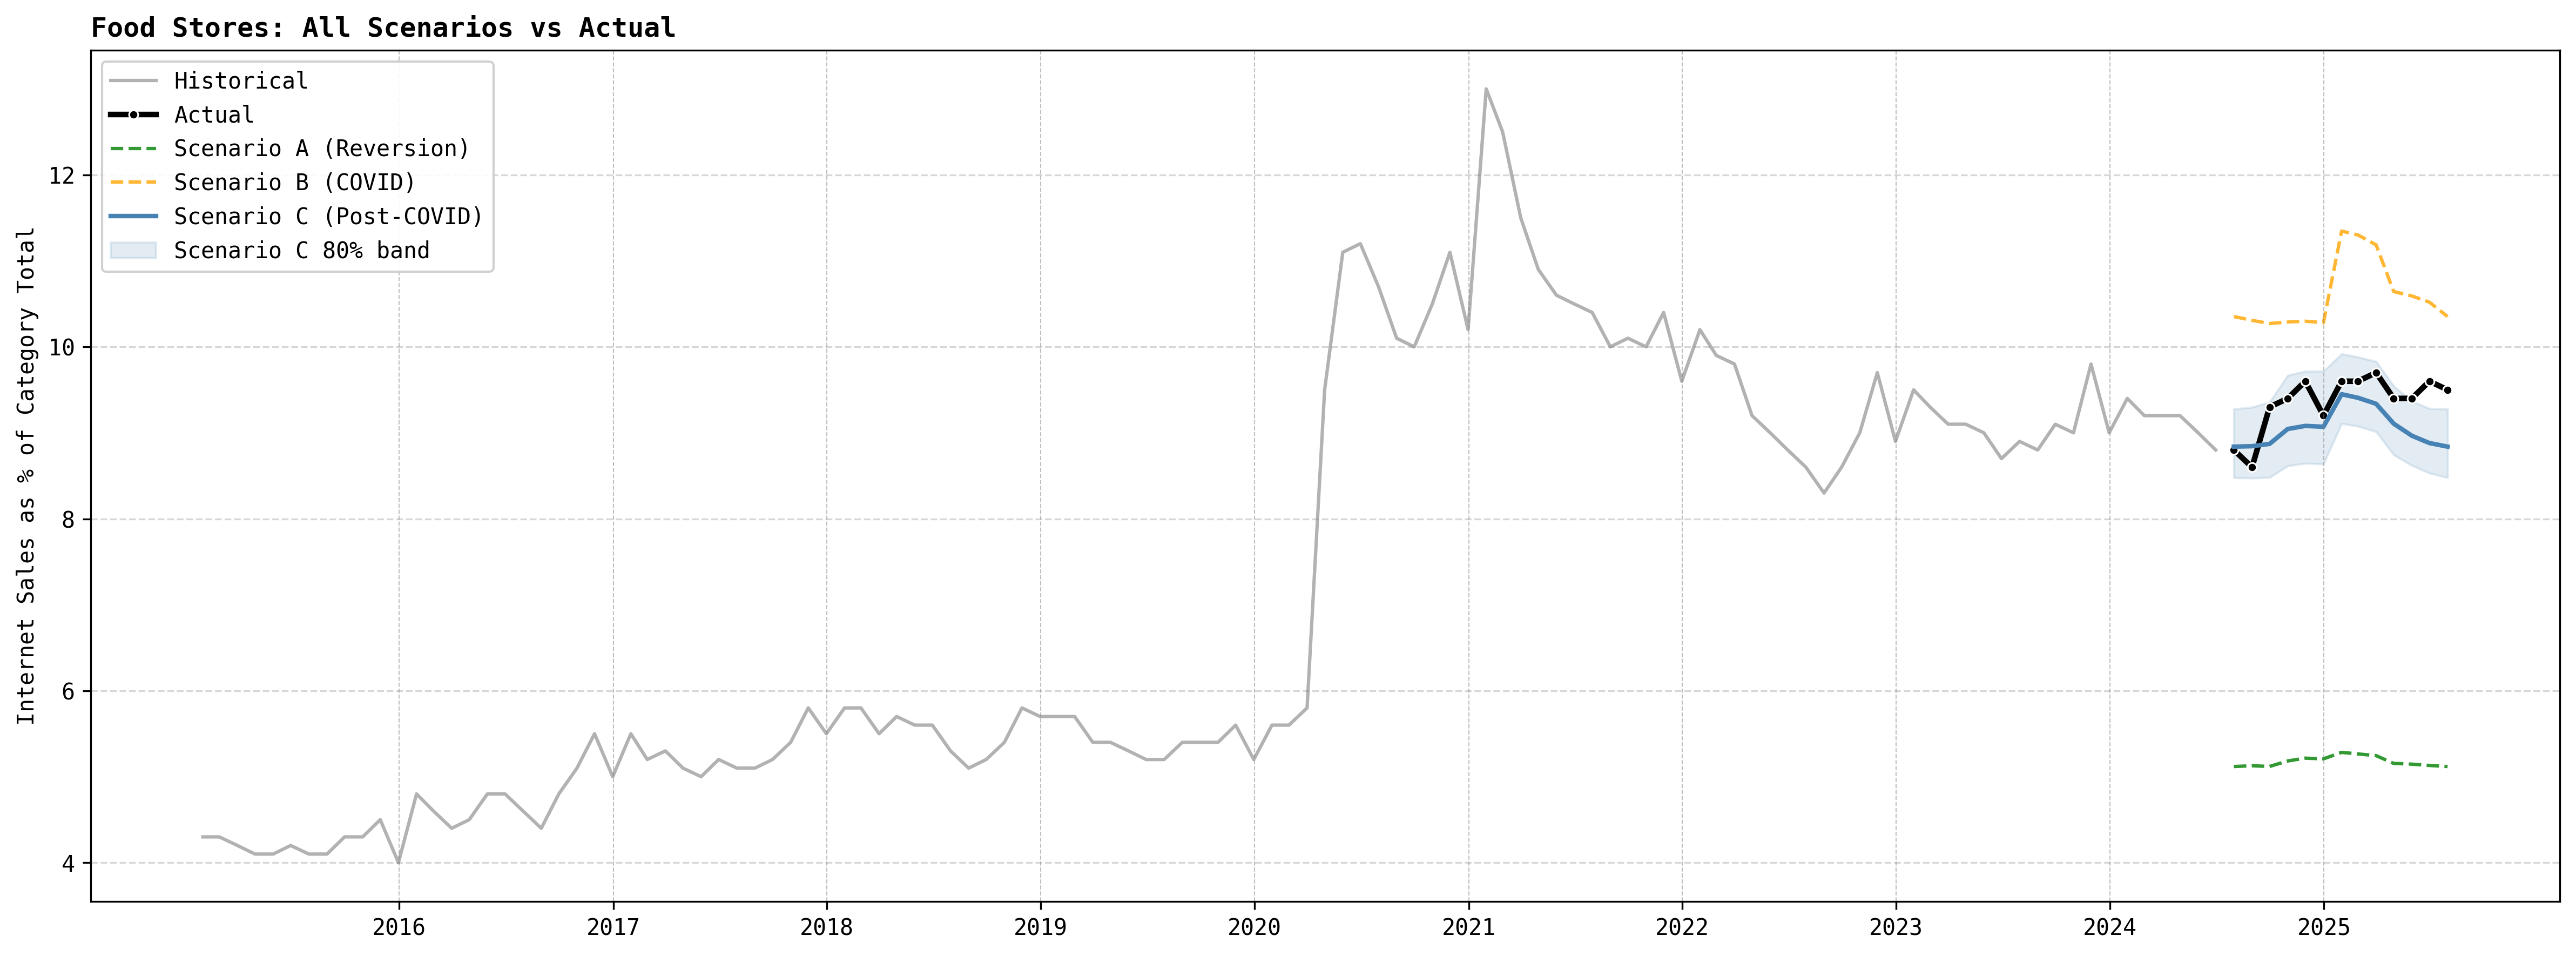

In [21]:
# Plot all scenarios together
plot_all_scenarios(
    pred_A=pred_A,
    pred_B=pred_B,
    pred_C=pred_C,
    train_tsdf=train_tsdf,
    test_tsdf_ground_truth=test_tsdf_ground_truth,
    category=test_category,
    save_path=output_figures_dir / f'{test_category}_all_scenarios.png'
)

## 5. Run All Categories × All Scenarios

In [22]:
# Run forecasts for all categories and scenarios
results = {}

for category in CATEGORIES:
    print(f"\n{'=' * 100}")
    print(f"Processing: {category.replace('_', ' ').title()}")
    print(f"{'=' * 100}")

    # Prepare data
    train_tsdf, test_tsdf_ground_truth = prepare_category_tsdf(df_categories, category, train_end)
    test_dates = test_tsdf_ground_truth.index.get_level_values('timestamp').unique()

    category_results = {}

    for scenario in ['A', 'B', 'C']:
        print(f"  Scenario {scenario}...", end=' ')

        # Create test set
        test_tsdf = create_scenario_test_tsdf(category, test_dates, scenario=scenario)

        # Predict
        pred = predictor.predict(train_tsdf, test_tsdf)

        # Evaluate
        metrics = evaluate_category_forecast(pred, train_tsdf, test_tsdf_ground_truth, category, HORIZON)

        # Store results
        category_results[scenario] = {
            'pred': pred,
            'metrics': metrics
        }

        print(f"MAE: {metrics['mae']:.3f}")

    # Store category results
    results[category] = {
        'train_tsdf': train_tsdf,
        'test_tsdf_ground_truth': test_tsdf_ground_truth,
        'scenarios': category_results
    }

print(f"\n✅ All forecasts complete!")


Processing: Food Stores
  Scenario A... 

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1058.90it/s]
Processing: 100%|██████████| [00:01<00:00]


MAE: 4.228
  Scenario B... 

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1637.12it/s]
Processing: 100%|██████████| [00:01<00:00]


MAE: 1.184
  Scenario C... 

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 2129.09it/s]
Processing: 100%|██████████| [00:01<00:00]


MAE: 0.381

Processing: Clothing Footwear
  Scenario A... 

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1506.57it/s]
Processing: 100%|██████████| [00:01<00:00]


MAE: 12.743
  Scenario B... 

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 2194.82it/s]
Processing: 100%|██████████| [00:01<00:00]


MAE: 5.358
  Scenario C... 

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1707.78it/s]
Processing: 100%|██████████| [00:01<00:00]


MAE: 1.542

Processing: Household Goods
  Scenario A... 

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1258.79it/s]
Processing: 100%|██████████| [00:01<00:00]


MAE: 13.113
  Scenario B... 

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1468.59it/s]
Processing: 100%|██████████| [00:01<00:00]


MAE: 2.779
  Scenario C... 

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1554.02it/s]
Processing: 100%|██████████| [00:01<00:00]


MAE: 1.570

Processing: Non Specialised
  Scenario A... 

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1299.35it/s]
Processing: 100%|██████████| [00:01<00:00]


MAE: 9.431
  Scenario B... 

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 2056.03it/s]
Processing: 100%|██████████| [00:01<00:00]


MAE: 5.080
  Scenario C... 

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1451.82it/s]
Processing: 100%|██████████| [00:01<00:00]


MAE: 1.565

Processing: Other Stores
  Scenario A... 

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1644.83it/s]
Processing: 100%|██████████| [00:01<00:00]


MAE: 12.657
  Scenario B... 

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1751.28it/s]
Processing: 100%|██████████| [00:01<00:00]


MAE: 2.494
  Scenario C... 

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1342.18it/s]
Processing: 100%|██████████| [00:01<00:00]


MAE: 3.474

Processing: Non Store Retail
  Scenario A... 

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1702.23it/s]
Processing: 100%|██████████| [00:01<00:00]


MAE: 10.291
  Scenario B... 

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1787.85it/s]
Processing: 100%|██████████| [00:00<00:00]


MAE: 1.601
  Scenario C... 

Predicting time series: 100%|██████████| 1/1 [00:00<00:00, 1431.50it/s]
Processing: 100%|██████████| [00:01<00:00]

MAE: 0.553

✅ All forecasts complete!


## 6. Summary: Best Scenario per Category

In [23]:
# Create summary table
summary_data = []

for category in CATEGORIES:
    cat_results = results[category]['scenarios']

    mae_A = cat_results['A']['metrics']['mae']
    mae_B = cat_results['B']['metrics']['mae']
    mae_C = cat_results['C']['metrics']['mae']

    best_scenario = min([('A', mae_A), ('B', mae_B), ('C', mae_C)], key=lambda x: x[1])[0]

    summary_data.append({
        'Category': category.replace('_', ' ').title(),
        'MAE Scenario A': mae_A,
        'MAE Scenario B': mae_B,
        'MAE Scenario C': mae_C,
        'Best Scenario': best_scenario,
        'Best MAE': min(mae_A, mae_B, mae_C)
    })

summary_df = pd.DataFrame(summary_data)
summary_df = summary_df.round(3)

print(f"\n{'=' * 100}")
print(f"SUMMARY: BEST SCENARIO BY CATEGORY (MAE)")
print(f"{'=' * 100}")
print(summary_df.to_string(index=False))

print(f"\nScenario distribution:")
print(summary_df['Best Scenario'].value_counts())


SUMMARY: BEST SCENARIO BY CATEGORY (MAE)
         Category  MAE Scenario A  MAE Scenario B  MAE Scenario C Best Scenario  Best MAE
      Food Stores           4.228           1.184           0.381             C     0.381
Clothing Footwear          12.743           5.358           1.542             C     1.542
  Household Goods          13.113           2.779           1.570             C     1.570
  Non Specialised           9.431           5.080           1.565             C     1.565
     Other Stores          12.657           2.494           3.474             B     2.494
 Non Store Retail          10.291           1.601           0.553             C     0.553

Scenario distribution:
Best Scenario
C    5
B    1
Name: count, dtype: int64


## 7. Visualize: Scenario Comparison

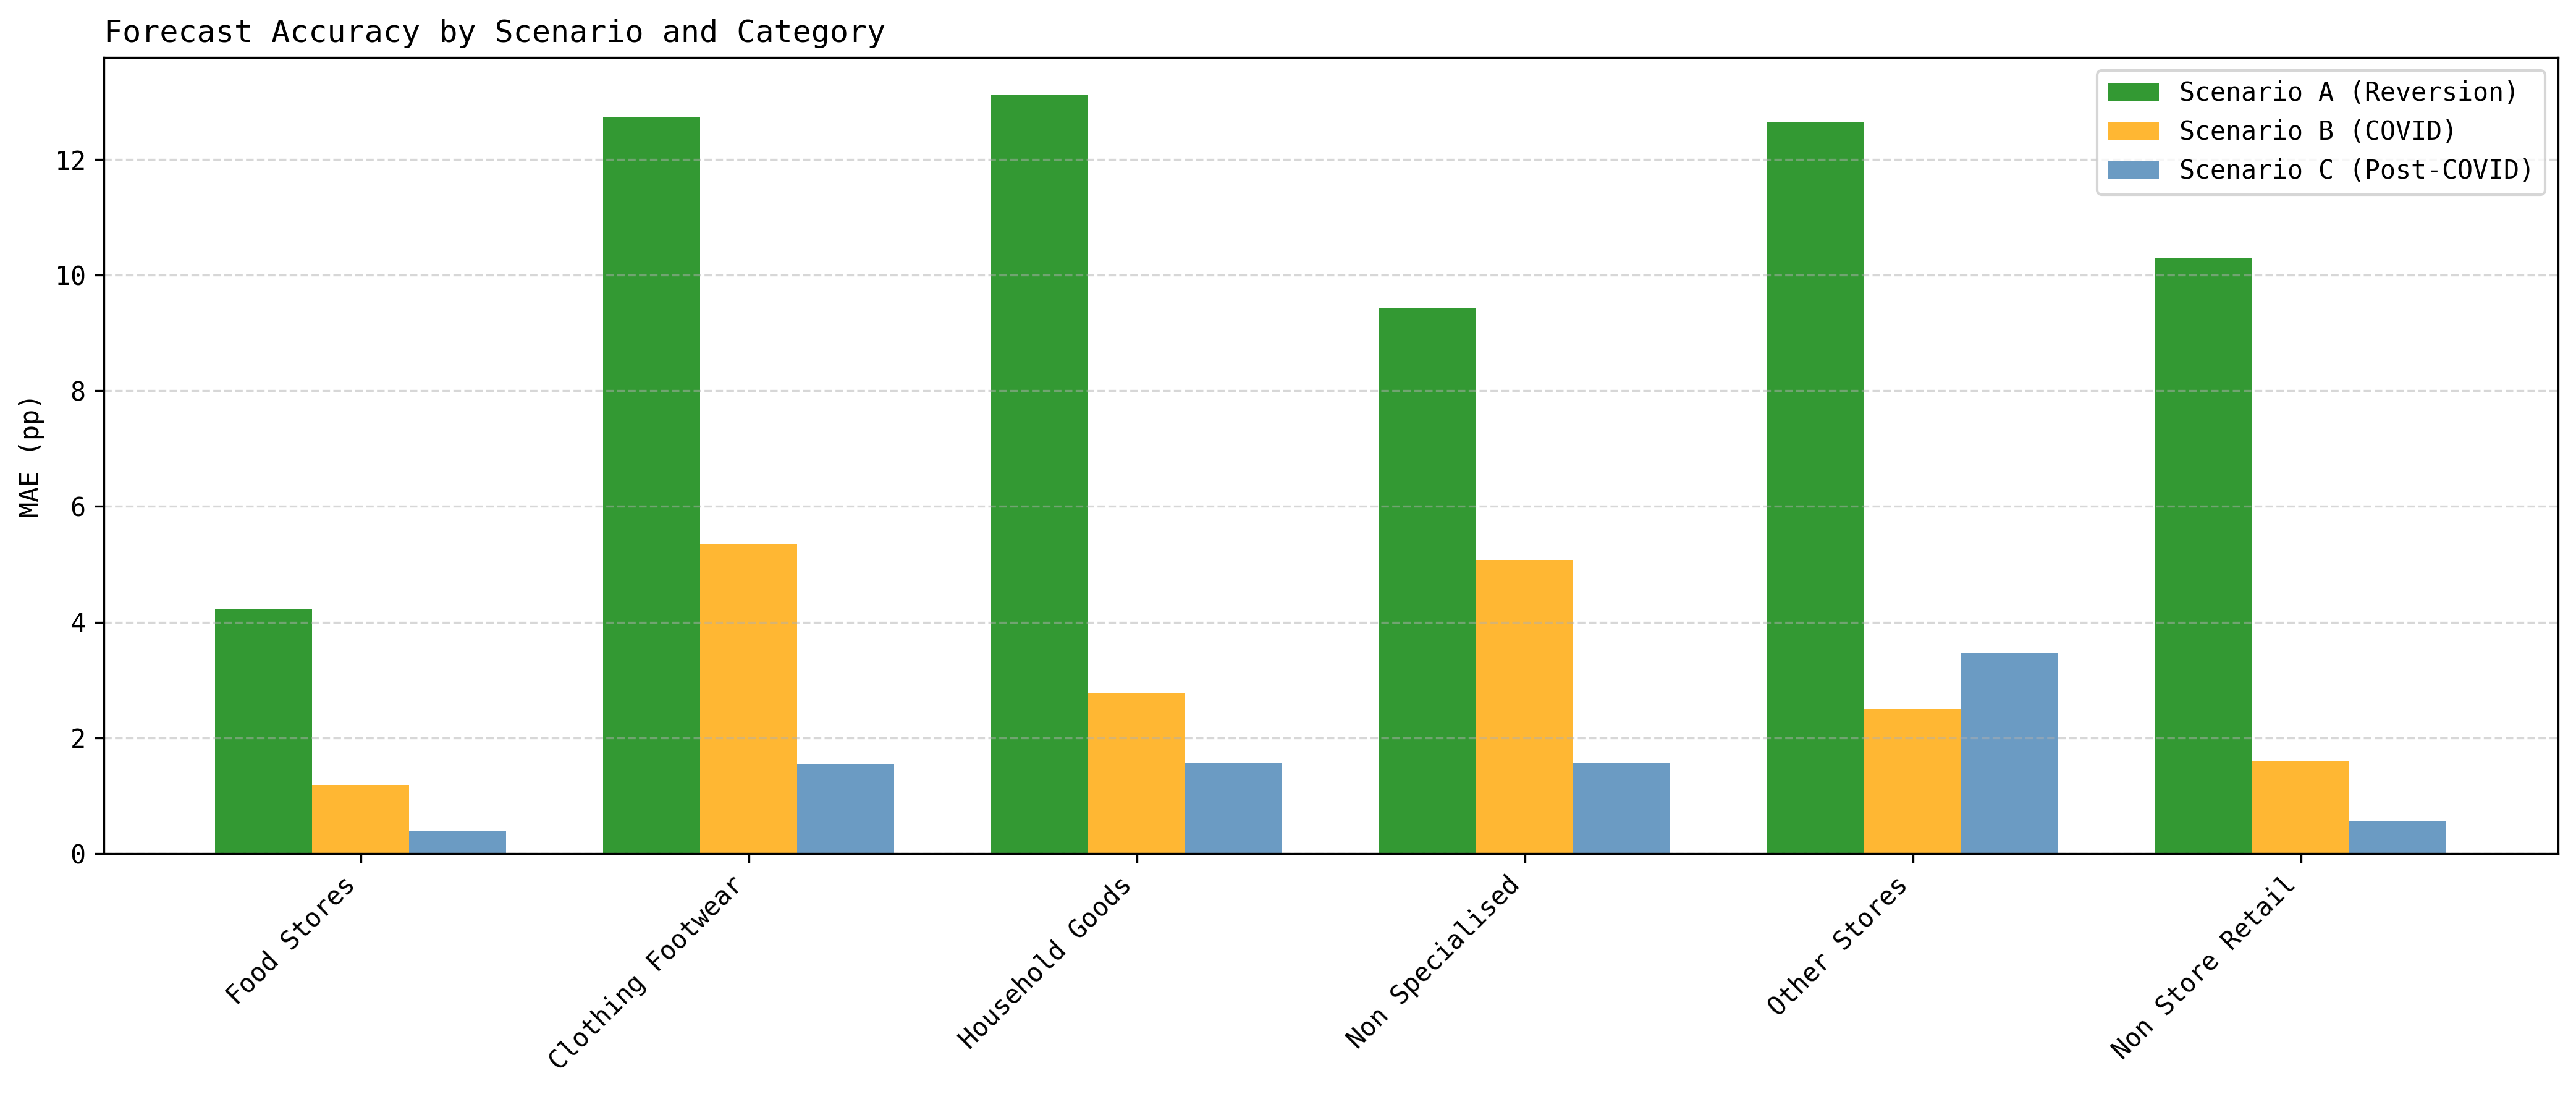

In [24]:
# Bar chart: MAE by scenario and category
fig, ax = plt.subplots(figsize=(14, 6), dpi=300)

x = np.arange(len(CATEGORIES))
width = 0.25

mae_A_vals = [results[cat]['scenarios']['A']['metrics']['mae'] for cat in CATEGORIES]
mae_B_vals = [results[cat]['scenarios']['B']['metrics']['mae'] for cat in CATEGORIES]
mae_C_vals = [results[cat]['scenarios']['C']['metrics']['mae'] for cat in CATEGORIES]

ax.bar(x - width, mae_A_vals, width, label='Scenario A (Reversion)', color='green', alpha=0.8)
ax.bar(x, mae_B_vals, width, label='Scenario B (COVID)', color='orange', alpha=0.8)
ax.bar(x + width, mae_C_vals, width, label='Scenario C (Post-COVID)', color='steelblue', alpha=0.8)

ax.set_ylabel('MAE (pp)')
ax.set_title('Forecast Accuracy by Scenario and Category', loc='left', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels([cat.replace('_', ' ').title() for cat in CATEGORIES], rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig(output_figures_dir / 'scenario_comparison_mae.png', bbox_inches='tight', dpi=300)
plt.show()

## 8. Save Results

In [25]:
# Save forecast results
forecast_results = {}

for category in CATEGORIES:
    cat_results = results[category]

    forecast_results[category] = {
        'scenarios': {
            'A': cat_results['scenarios']['A']['metrics'],
            'B': cat_results['scenarios']['B']['metrics'],
            'C': cat_results['scenarios']['C']['metrics']
        }
    }

output_path = processed_data_dir / 'category_forecast_results.pkl'
with open(output_path, 'wb') as f:
    pickle.dump(forecast_results, f)

print(f"✅ Forecast results saved to {output_path}")

✅ Forecast results saved to /home/mikhailarutyunov/projects/time-series-methods/time-series-methods/data/processed/category_forecast_results.pkl


In [26]:
# Save summary table
summary_df.to_csv(processed_data_dir / 'category_forecast_summary.csv', index=False)
print(f"✅ Summary table saved to {processed_data_dir / 'category_forecast_summary.csv'}")

✅ Summary table saved to /home/mikhailarutyunov/projects/time-series-methods/time-series-methods/data/processed/category_forecast_summary.csv


In [27]:
# Print completion message
print('\n' + '=' * 100)
print('📋 NOTEBOOK 06 COMPLETE')
print('=' * 100)
print(f'\nKey findings:')
print(f'  - Forecasted {len(CATEGORIES)} categories with 3 scenarios each')
print(f'  - Evaluated forecast accuracy on {HORIZON}-month holdout period')
print(f'  - Identified best scenario per category based on MAE')
print(f'\n✅ Ready for aggregation in notebook 07')


📋 NOTEBOOK 06 COMPLETE

Key findings:
  - Forecasted 6 categories with 3 scenarios each
  - Evaluated forecast accuracy on 12-month holdout period
  - Identified best scenario per category based on MAE

✅ Ready for aggregation in notebook 07
